In [14]:
import numpy as np
import pandas as pd
from pathlib import Path
from src.utils import construct_sparse_adj_mat, load_json
from omegaconf import OmegaConf
from src.similarity import rcmcs_similarity_matrix, homology_similarity_matrix
import matplotlib.pyplot as plt
from Bio import Align

In [15]:
filepaths = OmegaConf.load('../configs/filepaths/base.yaml')
reactions = load_json(Path(filepaths.data) / 'sprhea' / ('v3_folded_test' + ".json"))
rules = pd.read_csv(
            filepath_or_buffer=Path(filepaths.artifacts) / 'minimal1224_all_uniprot.tsv',
            sep='\t'
        )
rules.set_index('Name', inplace=True)

adj, idx_sample, idx_feature = construct_sparse_adj_mat(
        Path(filepaths.data) / 'sprhea' / ('v3_folded_test' + ".csv")
    )

reactions = {k: v for k, v in reactions.items() if k in idx_feature.values()}

toc = pd.read_csv(Path(filepaths.data) / 'sprhea' / 'v3_folded_test.csv', sep='\t')
pid2seq = {row['Entry']: row['Sequence'] for i, row in toc.iterrows()}
aligner = Align.PairwiseAligner(
            mode="local",
            scoring="blastp"
        )

Constructing v3_folded_test sparse adjacency matrix


In [18]:
strategy = 'homology'
split_dir = Path(filepaths.scratch) / f"sprhea_v3_folded_test/{strategy}/3fold"

train_val = []
for i in range(3):
    train_val.append(
        pd.read_parquet(split_dir / f"train_val_{i}.parquet")
    )
test = pd.read_parquet(split_dir / 'test.parquet')

In [19]:
train_val[0].head()

,protein_idx,reaction_idx,pid,rid,protein_embedding,smarts,reaction_center,y
0,89,154,P70265,2027,"[0.032134816, 0.18586083, -0.0042836606, -0.07...",O.O=P(O)(O)OCC1OC(CO)(OP(=O)(O)O)C(O)C1O>>O=P(...,"[[[0], [11, 12]], [[9], [2, 1]]]",1
1,89,155,P70265,1795,"[0.032134816, 0.18586083, -0.0042836606, -0.07...",Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)O)C(O)C1...,"[[[21], [11, 12]], [[9], [22, 23]]]",1
2,56,87,O13914,236,"[0.032134816, 0.18586083, -0.0042836606, -0.07...",*P(=O)(O)OCC1OC(n2cnc3c(N)ncnc32)C(O)C1O.CC(N)...,"[[[21, 22], [5], [18, 15]], [[21, 22], [2], [1...",1
3,75,134,Q874K0,2409,"[0.032134816, 0.18586083, -0.0042836606, -0.07...",CC(C)=CCCC(C)C1CCC2C3=C(CCC21C)C1(C)CCC(O)C(C)...,"[[[22, 23], [3, 4, 5, 6, 7, 47]], [[3, 4, 5, 4...",1
4,2,6,G2IJ05,7504,"[0.032134816, 0.18586083, -0.0042836606, -0.07...",CN1c2c(nc(N)[nH]c2=O)NCC1CNc1ccc(C(=O)NC(CCC(=...,"[[[0, 1], [10]], [[0, 1], [8]]]",1


In [20]:
print([len(elt) for elt in train_val])
print(len(test))

[643, 643, 279]
67


In [21]:
if strategy == 'rcmcs':
    S = rcmcs_similarity_matrix(
        reactions,
        rules,
        idx_feature
    )
elif strategy == 'homology':
    S, _ = homology_similarity_matrix(
        sequences=pid2seq,
        aligner=aligner,
    )

Preparing reaction pairs

Sequence # 98 : B4F9A4AH51
Processing pairs



100%|██████████| 4950/4950 [00:05<00:00, 888.51it/s] 


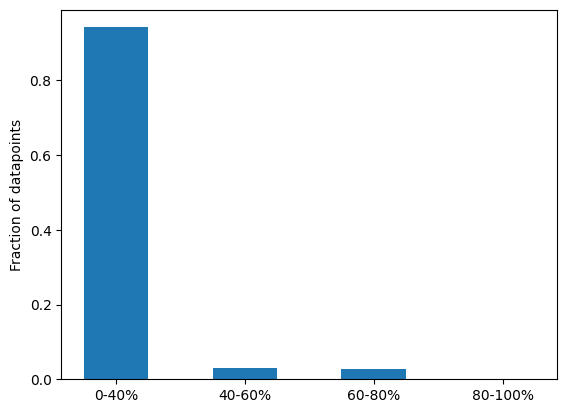

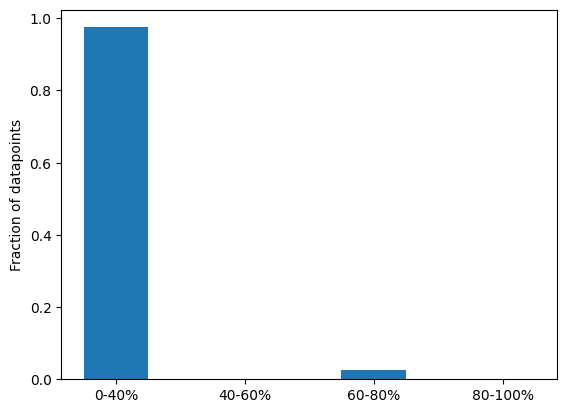

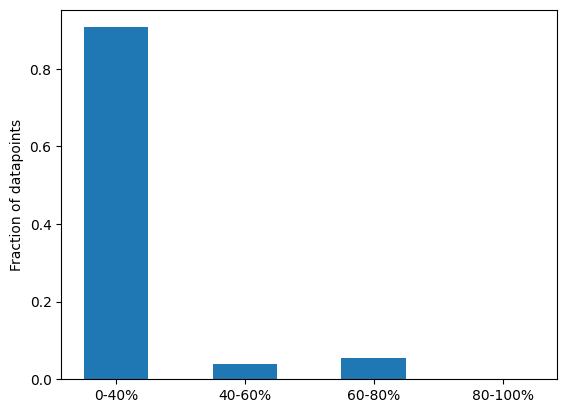

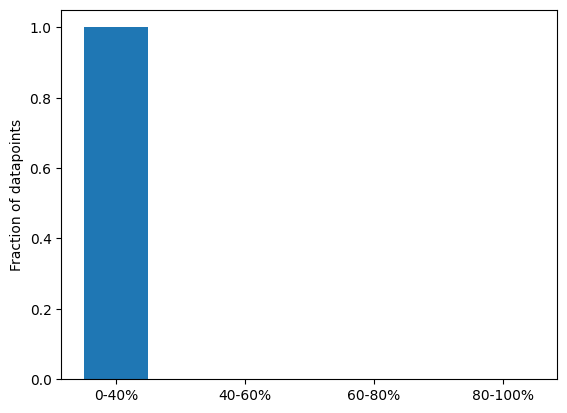

In [22]:
if strategy == 'rcmcs':
    key = 'reaction_idx'
elif strategy == 'homology':
    key = 'protein_idx'

thresholds = [1.0, 0.8, 0.6, 0.4]
thresholds = sorted(thresholds)
xticklabels = [f"0-{thresholds[0]*100:.0f}%"] + [f"{thresholds[j]*100:.0f}-{thresholds[j+1]*100:.0f}%" for j in range(len(thresholds) - 1)]

for i, val in enumerate(train_val):
    val_ridx = val[key].values
    train = pd.concat([train_val[j] for j in range(3) if j != i])
    train_ridx = train[key].values
    max_sims = S[train_ridx][:, val_ridx].max(axis=0)
    cdf = []
    for j, th in enumerate(thresholds):
        if j == 0:
            in_range = len(np.argwhere(max_sims <= th))
        else:
            less_than_th = len(np.argwhere(max_sims <= th))
            less_than_prev = len(np.argwhere(max_sims <= thresholds[j - 1]))
            in_range = less_than_th - less_than_prev
        
        cdf.append(in_range / len(max_sims))

    plt.bar(thresholds, cdf, width=0.1)
    plt.xticks(thresholds, xticklabels)
    plt.ylabel('Fraction of datapoints')
    plt.show()

val_ridx = test[key].values
train = pd.concat(train_val)
train_ridx = train[key].values
max_sims = S[train_ridx][:, val_ridx].max(axis=0)
cdf = []
for j, th in enumerate(thresholds):
    if j == 0:
        in_range = len(np.argwhere(max_sims <= th))
    else:
        less_than_th = len(np.argwhere(max_sims <= th))
        less_than_prev = len(np.argwhere(max_sims <= thresholds[j - 1]))
        in_range = less_than_th - less_than_prev
    
    cdf.append(in_range / len(max_sims))

plt.bar(thresholds, cdf, width=0.1)
plt.xticks(thresholds, xticklabels)
plt.ylabel('Fraction of datapoints')
plt.show()

In [23]:
for i, elt in enumerate(train_val):
    print(f"Fold {i}")
    print("+", len(elt[elt['y'] == 1]) / len(elt))
    print("-", len(elt[elt['y'] == 0]) / len(elt))

print(f"Test")
print("+", len(test[test['y'] == 1]) / len(test))
print("-", len(test[test['y'] == 0]) / len(test))

Fold 0
+ 0.10108864696734059
- 0.8989113530326595
Fold 1
+ 0.09797822706065319
- 0.9020217729393468
Fold 2
+ 0.1039426523297491
- 0.8960573476702509
Test
+ 0.5373134328358209
- 0.4626865671641791


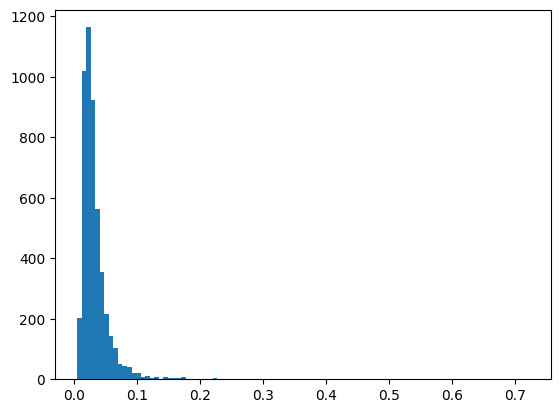

In [29]:
sims = S[np.triu_indices_from(S, k=1)]
plt.hist(sims, bins=100)
plt.show()